<a href="https://colab.research.google.com/github/SongZhou-Meg/shap/blob/master/LLM_and_customer_segmentation_Kprototypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let’s see 3 methods to approach this type of project:

method 2: K-Prototype

In [1]:
!pip install shap
!pip install pyod
!pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=066d94488c4cdc97c106ca9f023a3e8c632e80e1c54c06fe5b65becfab866213
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 6.5 MB/s eta 0:00:00


In [3]:
!pip install kmodes

In [4]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

from kmodes.kprototypes import KPrototypes
from plotnine import *
import plotnine

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# read data
data_path1 = '/content/drive/MyDrive/Data/LLM_cust_sege/train.csv'
df = pd.read_csv(data_path1, sep=';')
df = df.iloc[:, 0:8]

pipe = Pipeline([('ordinal', OrdinalEncoder()), ('scaler', PowerTransformer())])
pipe_fit = pipe.fit(df)

data = pd.DataFrame(pipe_fit.transform(df), columns = df.columns)
data

age       job   marital  education  default   balance   housing  \
0      1.469546  0.093094 -0.286301   1.029751 -0.13549  0.996466  0.893915   
1      0.417051  1.277591  1.379481  -0.254415 -0.13549 -0.775508  0.893915   
2     -0.693452 -0.579713 -0.286301  -0.254415 -0.13549 -0.818578  0.893915   
3      0.667539 -1.017980 -0.286301   2.201328 -0.13549  0.646343  0.893915   
4     -0.693452  1.652351  1.379481   2.201328 -0.13549 -0.820196 -1.118674   
...         ...       ...       ...        ...      ...       ...       ...   
45206  0.977930  1.277591 -0.286301   1.029751 -0.13549  0.142935 -1.118674   
45207  2.256815  0.371310 -1.892104  -1.734294 -0.13549  0.779764 -1.118674   
45208  2.312138  0.371310 -0.286301  -0.254415 -0.13549  1.914392 -1.118674   
45209  1.402760 -1.017980 -0.286301  -0.254415 -0.13549 -0.000442 -1.118674   
45210 -0.245723 -0.579713 -0.286301  -0.254415 -0.13549  1.337156 -1.118674   

           loan  
0     -0.436803  
1     -0.436803  
2      2.289359  
3     -0.436803  
4     -0.436803  
...         ...  
45206 -0.436803  
45207 -0.436803  
45208 -0.436803  
45209 -0.436803  
45210 -0.436803  

[45211 rows x 8 columns]

In [7]:
from pyod.models.ecod import ECOD
# https://github.com/yzhao062/pyod
clf = ECOD()
clf.fit(data)
outliers = clf.predict(data)

df["outliers"] = outliers

df_no_outliers = df[df["outliers"] == 0]
df_no_outliers = df_no_outliers.drop(["outliers"], axis = 1)

In [8]:
df_no_outliers

age           job  marital  education default  balance housing loan
0       58    management  married   tertiary      no     2143     yes   no
1       44    technician   single  secondary      no       29     yes   no
2       33  entrepreneur  married  secondary      no        2     yes  yes
3       47   blue-collar  married    unknown      no     1506     yes   no
5       35    management  married   tertiary      no      231     yes   no
...    ...           ...      ...        ...     ...      ...     ...  ...
45202   34        admin.   single  secondary      no      557      no   no
45204   73       retired  married  secondary      no     2850      no   no
45206   51    technician  married   tertiary      no      825      no   no
45209   57   blue-collar  married  secondary      no      668      no   no
45210   37  entrepreneur  married  secondary      no     2971      no   no

[40691 rows x 8 columns]

Dataset normalized without onehot preprocessing. Get the numeric features to modify their scale

In [9]:
pipe = Pipeline([('scaler', PowerTransformer())])

df_aux = pd.DataFrame(pipe_fit.fit_transform(df_no_outliers[["age", "balance"]] ), columns = ["age", "balance"])
df_no_outliers_norm = df_no_outliers.copy()

# Replace age and balance columns by preprocessed values
df_no_outliers_norm = df_no_outliers_norm.drop(["age", "balance"], axis = 1)
df_no_outliers_norm["age"] = df_aux["age"].values
df_no_outliers_norm["balance"] = df_aux["balance"].values
df_no_outliers_norm

job  marital  education default housing loan       age  \
0        management  married   tertiary      no     yes   no  1.593554   
1        technician   single  secondary      no     yes   no  0.476098   
2      entrepreneur  married  secondary      no     yes  yes -0.731532   
3       blue-collar  married    unknown      no     yes   no  0.743482   
5        management  married   tertiary      no     yes   no -0.475239   
...             ...      ...        ...     ...     ...  ...       ...   
45202        admin.   single  secondary      no      no   no -0.600614   
45204       retired  married  secondary      no      no   no  2.538978   
45206    technician  married   tertiary      no      no   no  1.073369   
45209   blue-collar  married  secondary      no      no   no  1.523015   
45210  entrepreneur  married  secondary      no      no   no -0.238887   

        balance  
0      1.109265  
1     -0.898751  
2     -0.958550  
3      0.756726  
5     -0.518504  
...         ...  
45202 -0.065297  
45204  1.395571  
45206  0.220663  
45209  0.060384  
45210  1.435096  

[40691 rows x 8 columns]

In [10]:
df_no_outliers

age           job  marital  education default  balance housing loan
0       58    management  married   tertiary      no     2143     yes   no
1       44    technician   single  secondary      no       29     yes   no
2       33  entrepreneur  married  secondary      no        2     yes  yes
3       47   blue-collar  married    unknown      no     1506     yes   no
5       35    management  married   tertiary      no      231     yes   no
...    ...           ...      ...        ...     ...      ...     ...  ...
45202   34        admin.   single  secondary      no      557      no   no
45204   73       retired  married  secondary      no     2850      no   no
45206   51    technician  married   tertiary      no      825      no   no
45209   57   blue-collar  married  secondary      no      668      no   no
45210   37  entrepreneur  married  secondary      no     2971      no   no

[40691 rows x 8 columns]

DataSet with onehot preprocessing AND normalized

In [11]:
data["outliers"] = outliers
data_no_outliers = data[data["outliers"] == 0]
data_no_outliers = data_no_outliers.drop(["outliers"], axis = 1)

In [12]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

categorical_columns = df_no_outliers_norm.select_dtypes(exclude=numerics).columns
print(categorical_columns)
categorical_columns_index = [df_no_outliers_norm.columns.get_loc(col) for col in categorical_columns]

Index(['job', 'marital', 'education', 'default', 'housing', 'loan'], dtype='object')


In [14]:
# Choose optimal K using Elbow method

cost = []
range_ = range(2, 15)
for cluster in range_:

         kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
         kprototype.fit_predict(df_no_outliers_norm, categorical = categorical_columns_index)
         cost.append(kprototype.cost_)
         print('Cluster initiation: {}'.format(cluster))

 # Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range_, 'Cost':cost})
 # Data viz
plotnine.options.figure_size = (8, 4.8)
(
     ggplot(data = df_cost)+
     geom_line(aes(x = 'Cluster',
                   y = 'Cost'))+
     geom_point(aes(x = 'Cluster',
                    y = 'Cost'))+
     geom_label(aes(x = 'Cluster',
                    y = 'Cost',
                    label = 'Cluster'),
                size = 10,
                nudge_y = 1000) +
     labs(title = 'Optimal number of cluster with Elbow Method')+
     xlab('Number of Clusters k')+
     ylab('Cost')+
     theme_minimal()
 )
# it took too long to run

ValueError: ignored

**We are going to use k=5 and Kpropotype, This model allows us to use mixed dataframes (numeric and categorical variables)**





In [15]:
df_no_outliers_norm

job  marital  education default housing loan       age  \
0        management  married   tertiary      no     yes   no  1.593554   
1        technician   single  secondary      no     yes   no  0.476098   
2      entrepreneur  married  secondary      no     yes  yes -0.731532   
3       blue-collar  married    unknown      no     yes   no  0.743482   
5        management  married   tertiary      no     yes   no -0.475239   
...             ...      ...        ...     ...     ...  ...       ...   
45202        admin.   single  secondary      no      no   no -0.600614   
45204       retired  married  secondary      no      no   no  2.538978   
45206    technician  married   tertiary      no      no   no  1.073369   
45209   blue-collar  married  secondary      no      no   no  1.523015   
45210  entrepreneur  married  secondary      no      no   no -0.238887   

        balance  
0      1.109265  
1     -0.898751  
2     -0.958550  
3      0.756726  
5     -0.518504  
...         ...  
45202 -0.065297  
45204  1.395571  
45206  0.220663  
45209  0.060384  
45210  1.435096  

[40691 rows x 8 columns]

In [16]:
cluster_num = 5
kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster_num, init = 'Huang', random_state = 0)
kprototype.fit(df_no_outliers_norm, categorical = categorical_columns_index)

clusters = kprototype.predict(df_no_outliers_norm , categorical = categorical_columns_index)

In [17]:
clusters

array([3, 0, 0, ..., 4, 4, 1], dtype=uint16)

In [18]:
# Cluster centorid
print(kprototype.cluster_centroids_)
# Check the iteration of the clusters created
print(kprototype.n_iter_)
# Check the cost of the clusters created
print(kprototype.cost_)

[['-0.1564554149154047' '-0.735171761943619' 'blue-collar' 'married'
  'secondary' 'no' 'yes' 'no']
 ['-0.5054637442247827' '1.1672867942222223' 'management' 'married'
  'secondary' 'no' 'yes' 'no']
 ['-1.257533838380415' '-0.3660419602667484' 'management' 'single'
  'secondary' 'no' 'yes' 'no']
 ['1.056498228581658' '1.1957785879213194' 'management' 'married'
  'secondary' 'no' 'no' 'no']
 ['1.092226781124627' '-0.48237604154261615' 'management' 'married'
  'secondary' 'no' 'no' 'no']]
13
63047.827818635844


In [19]:
from prince import MCA

def get_MCA_3d(df, predict):

    mca = MCA(n_components =3, n_iter = 100, random_state = 101)

    mca_3d_df = mca.fit_transform(df)
    mca_3d_df.columns = ["comp1", "comp2", "comp3"]
    mca_3d_df["cluster"] = predict

    return mca, mca_3d_df



def get_MCA_2d(df, predict):

    mca = MCA(n_components =2, n_iter = 100, random_state = 101)

    mca_2d_df = mca.fit_transform(df)
    mca_2d_df.columns = ["comp1", "comp2"]
    mca_2d_df["cluster"] = predict

    return mca, mca_2d_df

mca_3d, mca_3d_df = get_MCA_3d(df_no_outliers_norm, clusters)

In [20]:
mca_3d_df

comp1     comp2     comp3  cluster
0     -0.254391  1.068586 -0.299286        3
1     -0.266283 -0.270035  0.122622        0
2      0.062269 -0.295689 -0.143010        0
3      0.342681 -0.166842 -0.396803        3
5     -0.400769  0.389465 -0.489270        0
...         ...       ...       ...      ...
45202 -0.333725 -0.224912  0.284518        2
45204  2.259727  2.312923  3.438660        3
45206 -0.152410  0.349753 -0.294224        4
45209  0.720811  0.169274  0.248605        4
45210  0.210983  0.065520 -0.230415        1

[40691 rows x 4 columns]

In [21]:
mca_3d.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.275         0.04%                      0.04%
1              0.263         0.03%                      0.07%
2              0.233         0.03%                      0.10%

In [22]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d


In [23]:
def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d

In [24]:
def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df,
                        x='comp1',
                        y='comp2',
                        z='comp3',
                        color='cluster',
                        template="plotly",

                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000,
                                height = 800,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()


In [25]:
def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df,
                        x='comp1',
                        y='comp2',
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800,
                                height = 700,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()

In [26]:
plot_pca_3d(mca_3d_df, title="MCA Space", opacity=1, width_line = 0.1)

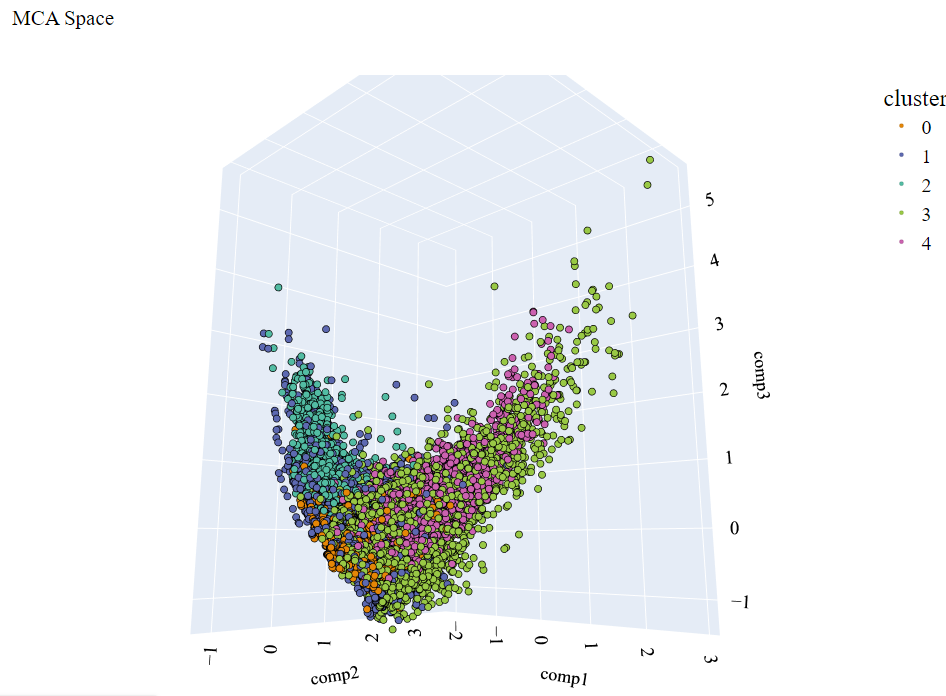

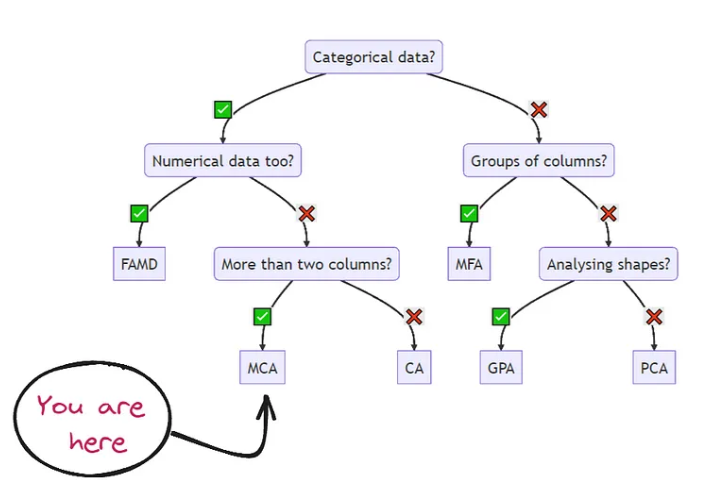

In [27]:
mca_2d, mca_2d_df = get_MCA_2d(df_no_outliers_norm, clusters)

In [28]:
plot_pca_2d(mca_3d_df, title="MCA Space", opacity=1, width_line = 0.5)


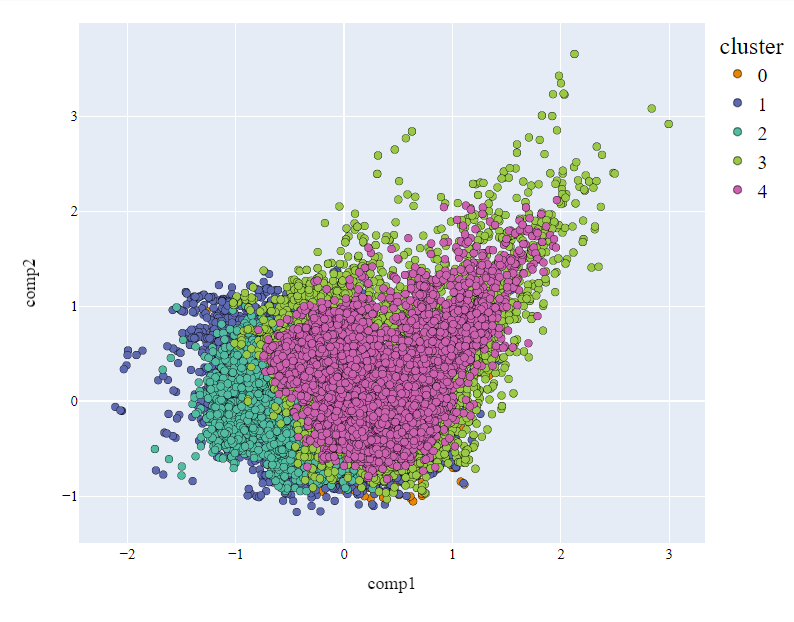



We can obtain the components of the PCA analysis and represent the identified clusters by the kprototype algorithm

In [29]:
pca_3d_object, df_pca_3d = get_pca_3d(data_no_outliers, clusters)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              1.493        18.66%                     18.66%
1              1.322        16.53%                     35.19%
2              1.055        13.18%                     48.37%


In [30]:
pca_2d_object, df_pca_2d = get_pca_2d(data_no_outliers, clusters)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.5)

Features importance

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 40691, number of used features: 8
[LightGBM] [Info] Start training from score -1.288309
[LightGBM] [Info] Start training from score -1.737218
[LightGBM] [Info] Start training from score -1.627316
[LightGBM] [Info] Start training from score -1.949529
[LightGBM] [Info] Start training from score -1.563239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


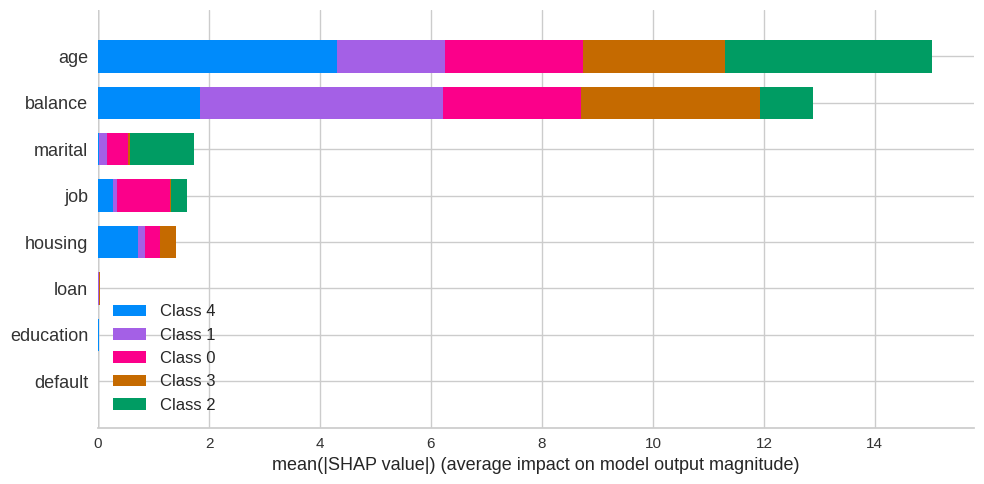

In [31]:
import lightgbm as lgb
import shap


clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)



for col in ["job", "marital", "education", "housing", "loan", "default"]:
    df_no_outliers_norm[col] = df_no_outliers_norm[col].astype('category')


clf_km.fit(X = df_no_outliers_norm , y = clusters, feature_name = "auto", categorical_feature = "auto")
# clf_km.fit(X = df_prueba, y = predict_embedding, feature_name='auto', categorical_feature = 'auto')
#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(df_no_outliers_norm)
shap.summary_plot(shap_values_km, df_no_outliers_norm, plot_type="bar", plot_size=(10, 5))

In [32]:
df_no_outliers = df[df.outliers == 0]
df_no_outliers["cluster"] = clusters

df_no_outliers.groupby('cluster').agg(
    {
         'age':'mean',
        'balance': 'mean',

        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'default': lambda x: x.value_counts().index[0],

    }
).sort_values("balance").reset_index()

<ipython-input-32-4dc0415339ab>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster        age      balance          job  marital  education housing  \
0        0  38.017558   176.943316  blue-collar  married  secondary     yes   
1        4  51.554500   302.270679   management  married  secondary      no   
2        2  29.730673   391.930198   management   single  secondary     yes   
3        1  35.107512  3089.760262   management  married  secondary     yes   
4        3  51.142783  3101.546961   management  married  secondary      no   

  loan default  
0   no      no  
1   no      no  
2   no      no  
3   no      no  
4   no      no